In [1]:
from MSMs import MSM
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import matplotlib as mpl
import statsmodels.api as sm
mpl.rcParams["font.size"]=18

In [2]:
msm = MSM()
num_states = 5

msm.num_states = num_states
msm._init_sample_K(dim=2, plot_init_fes=True)
msm._compute_peq_fes_K()
msm._build_MSM_from_K()
# msm._compute_peq_fes_M()
rate = msm.K.T


In [3]:
num_states = 5 # in each direction

x = [1 for i in range((num_states**2-1))]
x += [0 for i in range((num_states**2-1))]

y = [1 for i in range((num_states**2-1))]
y += [0 for i in range((num_states**2-1))]
x0 = x+y
x0 = np.asarray(x0)


def index2D(i,j,N):
    return i + N*j


def rate_mod_construct(num_states, n_states, x, target=[4,4]):
    rate_mod = np.eye(n_states,dtype=np.float64)

    xx = x[:len(x)//2]
    yy = x[len(x)//2:]
    stride = int(len(xx) // 2)
    tx = target[0]
    ty = target[1]

    
    for i in range(num_states):
            for j in range(num_states):
                i2d = index2D(i,j,num_states)
                if tx > i:
                    if i2d  <  num_states**2-1:
                        rate_mod[i2d,i2d+1] = xx[i2d]
                        # test.append(i2d)
                    if i2d > 0:
                        rate_mod[i2d,i2d-1] = xx[stride + i2d-1]
                        # test.append(stride + i2d-1)
                elif tx < i:
                    if i2d  <  num_states**2-1:
                        rate_mod[i2d,i2d+1] = xx[stride + i2d-1]
                        # test.append(stride + i2d-1)
                    if i2d > 0:
                        rate_mod[i2d,i2d-1] = xx[i2d-1]
                        # test.append(i2d-1)
                
                else:
                    if i2d  <  num_states**2-1:
                        rate_mod[i2d,i2d+1] = xx[stride + i2d]
                        # test.append(stride + i2d-1)
                    if i2d > 0:
                        rate_mod[i2d,i2d-1] = xx[stride + i2d-1]
                        # test.append(stride + i2d-1)

                if ty > j:
                    if i2d-num_states >= 0:
                        rate_mod[i2d, i2d - num_states] = yy[stride + i2d-1]
                    if i2d+num_states < num_states**2:
                        rate_mod[i2d, i2d + num_states] = yy[i2d]
                
                elif ty < j:
                    if i2d - num_states >= 0:
                        rate_mod[i2d, i2d - num_states] = yy[i2d-1]
                    if i2d + num_states < num_states**2:
                        rate_mod[i2d, i2d + num_states] = yy[stride + i2d-1]
                        
                else:
                    if i2d - num_states >= 0:
                        rate_mod[i2d, i2d - num_states] = yy[stride + i2d-1]
                        
                    if i2d + num_states < num_states**2:
                        rate_mod[i2d, i2d + num_states] = yy[stride + i2d]
                        
    return rate_mod

In [4]:
def rate_2D_irrv(rate, rate_mod, peq, n_states, p_mod=None):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    rate : np.array(n_states,n_states)
        Reversible rate matrix.
    rate_mod : np.array(n_states,n_states)
        Number of bins.
    peq : np.array(n_states)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.
    p_mod : np.array(n_states)
        Vector with alpha parameters.
    inter_rate_type : str
        "SH1", "TCV1", "TCV2" or "TCV3"

    Returns
    -------
    irrev_rate : np.array(2*n_states,2*n_states)
        Irreversible rate matrix.
    """

    irrev_rate = np.zeros((n_states * 2, n_states * 2))
    irrev_rate[:n_states, :n_states] = rate



    for i in range(n_states):
        for j in range(n_states):
            # k^{(\epsilon)}
            irrev_rate[i, j] = irrev_rate[i, j] * rate_mod[i, j]

            # Skewed detailed balanced condition
            # \pi_i k_{ij}^{(\epsilon)} = \pi_j k_{ji}^{(-\epsilon)}
            # k^{(-\epsilon)}
            irrev_rate[j + n_states, i + n_states] = irrev_rate[i, j] * (peq[i] / peq[j])
    

    if p_mod is None:
        p_mod = np.zeros(n_states)


    for i in range(n_states):
        irrev_rate[i, i] = 0.0
        irrev_rate[i + n_states, i + n_states] = 0.0
        sum0 = np.sum(irrev_rate[i + n_states, n_states:] - irrev_rate[i, :n_states])
        if sum0 > 0:
            irrev_rate[i, i + n_states] = sum0 + p_mod[i]
            irrev_rate[i + n_states, i] = p_mod[i]
        else:
            irrev_rate[i, i + n_states] = p_mod[i]
            irrev_rate[i + n_states, i] = p_mod[i] - sum0

    for i in range(2 * n_states):
        # Set diagonal elements of block matrices to 0
        irrev_rate[i, i] = 0.0
        irrev_rate[i, i] = -np.sum(irrev_rate[i, :])

    return irrev_rate

def compute_eig(matrix, sorted=True):
    """
    Calculates the eigenvalues and eigenvectors of a matrix.

    Parameters
    ----------
    matrix : np.array
        Matrix
    sorted : bool
        If True, returns eigenvalues and eigenvectors sorted in a descending order.

    Returns
    -------
    eigenvalues, eigenvectors : np.array, np.array
        Eigenvalues and eigenvectors
    """
    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    if sorted:
        index = np.argsort(eigenvalues)
        index = index[::-1]
        eigenvalues_sorted = eigenvalues[index]
        eigenvectors_sorted = eigenvectors[:, index]
        return eigenvalues_sorted, eigenvectors_sorted

    return eigenvalues, eigenvectors

def relxaton_time(rate):
    eigenvalues, eigenvectors = compute_eig(rate)
    return 1. / np.abs(eigenvalues[1])

def time_sampler(M_t,n_states,irrev=False):
    states = np.arange(0,n_states,1)
    state_start = 0
    P = M_t[state_start,:]
    t = 0
    new_state = 0
    if irrev:
        while new_state != n_states-1 and new_state != n_states//2-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            t += 1
    else:
        while new_state != n_states-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            t += 1

    return t


def simple_sampler(M_t,sim_time,n_states,final = False,initial=False):
    states = np.arange(0,n_states,1)
    state_start = np.random.randint(0,n_states)
    if initial:
        state_start = 0
    P = M_t[state_start,:]
    traj = np.zeros(sim_time,dtype=int)
    traj[0] = state_start
    for i in range(1,sim_time):
        new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
        traj[i] = new_state; # record the new state.
        P = M_t[new_state,:]
    if final:
        return new_state
    return traj


def sample_traj(M_t,sim_time,n_states,n_samples,irrev = False):
    pop = []
    for n in range(n_samples):
        pop.append(simple_sampler(M_t,sim_time,n_states))
    pop = np.array(pop)
    if irrev:
        pop[pop > n_states/2-1] -= int(n_states/2)
        # for i in pop:
        #     if i > n_states/2-1:
        #         i-=n_states/2
        # return np.array(pop_n).reshape(n_samples,sim_time)

    return np.array(pop).reshape(n_samples,sim_time)


def averge_difference(dsb1,dsb2):
    n1 = dsb1/np.sum(dsb1)
    n2 = dsb2/np.sum(dsb2)
    return np.average(abs(n1-n2))



# Auto Correlation

def autocorrelation_function(series):

    return abs(sm.tsa.acf(series,nlags=len(series)))


def average_correlation(M,N,r=100,irrev=False):    
    AC_array = np.zeros((1000,r))
    traj_array = np.zeros((1000,r))
    for i in range(1000):
        traj = simple_sampler(M,r,N,initial=True)
        traj_array[i,:] = traj
        if len(traj)>=r:
            AC_array[i,:] = autocorrelation_function(traj)[:r]
        else:
            AC_array[i,:len(traj)] = autocorrelation_function(traj)[:r]
    return np.average(AC_array,0),np.std(AC_array,0), traj_array

In [5]:
rate_mod = rate_mod_construct(num_states, 25, x0, target=[1,1])
rate_irrev = rate_2D_irrv(rate, rate_mod, msm.peq, 25, p_mod=None)

In [30]:
print(relxaton_time(rate))
print(relxaton_time(rate_irrev))

12.990915339166447
12.325594331908816


## MFTP

In [31]:
irrev_msm = MSM()
irrev_msm.K = rate_irrev.T
irrev_msm.num_states = 2*num_states
irrev_msm.num_dimensions = 2
ipeq = np.zeros(2*len(msm.peq))
ipeq[:len(msm.peq)] = msm.peq/2
ipeq[len(msm.peq):] = msm.peq/2
irrev_msm._compute_peq_fes_K()
irrev_msm._build_mfpt_matrix_K(2*num_states**2)

c:\Users\zdfjf\2023-24\ProjectImage\MSMs.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  mfpts[i, j] = 1 / self.peq[j] * (Qinv[j,j] - Qinv[i,j])


0

In [32]:
print(irrev_msm.mfpts[0,-1])
print(irrev_msm.mfpts[0,24])
print(irrev_msm.mfpts[-1,index2D(1,1,5)])
print(irrev_msm.mfpts[-1,24+index2D(1,1,5)])

120.35448452328184
120.37823514639726
15.93206170302049
18.63377885033586


In [33]:
msm._build_mfpt_matrix_K()
print(msm.mfpts[0,-1])

95.15281442582017


In [35]:
n = 1000
result = []

for i in range(n):
    result.append(time_sampler(msm.M.T,num_states**2))

print(np.average(result)/10,"±",np.std(result)/10)

206.454 ± 210.6784537251021


In [36]:
result2 = []
M_irrev = linalg.expm(0.1*rate_irrev)

for i in range(n):
    result2.append(time_sampler(M_irrev,2*num_states**2,irrev=True))

print(np.average(result)/10,"±",np.std(result)/10)
print(np.average(result2)/10,"±",np.std(result2)/10)

206.454 ± 210.6784537251021
204.83649999999997 ± 198.1541853147442


## KL Divergence

In [38]:
maxit = 500
prev1 = sample_traj(msm.M.T,maxit,num_states**2,10000)
prev2 = sample_traj(M_irrev,maxit,2*num_states**2,10000,irrev=True)

In [39]:
N = num_states**2
prev1c = np.zeros((maxit,N),dtype=int)
for i  in range(maxit):
    for n in prev1[:,i]:
        prev1c[i,n] +=1

prev2c = np.zeros((maxit,N),dtype=int)
for i  in range(maxit):
    for n in prev2[:,i]:
        prev2c[i,n] +=1



ent1 = []
ent2 = []

for i in range(maxit):
    ent1.append(averge_difference(msm.peq,prev1c[i,:]))
    ent2.append(averge_difference(msm.peq,prev2c[i,:]))

## Optimization

In [6]:
from scipy.optimize import minimize



def loss_rate_mod(x, rate, peq, n_states, bound=True):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    x : np.array
        Optimisable paramters.
    rate : np.array(ndim,ndim)
        Reversible rate matrix.
    peq : np.array(ndim)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.

    Returns
    -------
    loss : float
        Loss funtion values
    """
    if bound:
        # Bound the optimal x to be between 0 and 1
        x[x > 1] = 1
        x[x < 0] = 0

    # Construct rate mod
    rate_mod = rate_mod_construct(num_states,n_states,x,target=[1,1])

    # Construct the transition matrix from x
    irrev_rate = rate_2D_irrv(rate, rate_mod, peq, n_states)
    #irrev_rate = np.transpose(irrev_rate)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(irrev_rate, sorted=True)

    # Relaxation time is the second largest eigenvalue
    t2 = 1 / np.abs(eigenvalues[1].real)
    loss = t2

    # Kemeny constant
    # kemeny = np.sum(1 / np.abs(eigenvalues[1].real))
    # loss = - kemeny

    return loss

def skewness_optimize(rate, peq, n_states):
    # --------------------------------------------------- #
    #            Optimise the Skewness Function           #
    # --------------------------------------------------- #
    # Initial guess
    x = [1 for i in range((num_states**2-1))]
    x += [0 for i in range((num_states**2-1))]

    y = [1 for i in range((num_states**2-1))]
    y += [0 for i in range((num_states**2-1))]
    x0 = x+y
    x0 = np.asarray(x0)

    current_loss = loss_rate_mod(x0, rate, peq, n_states)
    f_vals = []
    x_vals = []
    

    res = minimize(loss_rate_mod, x0, args=(rate, peq, n_states),
                    method="trust-constr",
                    options={'maxiter': 400, 'xtol': 1e-5, 'gtol': 1e-6},
                    # options={'iprint': 2, 'disp': True, 'ftol': 1e-8, 'maxiter': 100000},
                    jac="2-point",
                    bounds=[[0, 1] for x in range(4 * n_states - 4)])
    
    f_vals.append(current_loss)
    x_vals.append(res.x)
    previous_loss = current_loss
    current_loss = loss_rate_mod(res.x, rate, peq, n_states)
    x0 = res.x

    min_idx = np.argmin(f_vals)
    res.x = x_vals[min_idx]

    # Bound optimal skewness function (just in case)
    res.x[res.x > 1] = 1.
    res.x[res.x < 0] = 0.

    return res


def opt_eigs(rate, peq, n_states):


    res = skewness_optimize(rate, peq, n_states)
    #print(res.x.shape)

    # Construct rate mod
    rate_mod = rate_mod_construct(num_states,n_states,res.x,target=[1,1])

    # Construct optimised transtion matrix
    opt_rate = rate_2D_irrv(rate, rate_mod, peq, n_states)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(opt_rate, sorted=True)
    rel_time = 1 / np.abs(eigenvalues[1].real)

    return rel_time,opt_rate

In [7]:
opt_rt,opt_rate = opt_eigs(rate, msm.peq, num_states**2)

In [42]:
opt_msm = MSM()
opt_msm.K = opt_rate.T
opt_msm.num_states = 2*num_states
opt_msm.num_dimensions = 2
opt_msm._compute_peq_fes_K()
opt_msm._build_mfpt_matrix_K(2*num_states**2)

0

In [43]:
print(opt_rt)
print(opt_msm.mfpts[0,-1])
print(opt_msm.mfpts[0,num_states**2-1])

5.928325743986153
151.22285108076147
155.72338729457258


In [8]:
def loss_rate_mod_mfpt(x, rate, peq, n_states, bound=True):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    x : np.array
        Optimisable paramters.
    rate : np.array(ndim,ndim)
        Reversible rate matrix.
    peq : np.array(ndim)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.

    Returns
    -------
    loss : float
        Loss funtion values
    """
    if bound:
        # Bound the optimal x to be between 0 and 1
        x[x > 1] = 1
        x[x < 0] = 0

    # Construct rate mod
    rate_mod = rate_mod_construct(num_states,n_states,x)

    # Construct the transition matrix from x
    irrev_rate = rate_2D_irrv(rate, rate_mod, peq, n_states)
    #irrev_rate = np.transpose(irrev_rate)

    # Get eigenvalues and eigenvectors of the transition matrix
    opt_msm = MSM()
    opt_msm.K = irrev_rate.T
    opt_msm.num_states = 2*num_states
    opt_msm.num_dimensions = 2
    opt_msm._compute_peq_fes_K()
    opt_msm._build_mfpt_matrix_K(2*num_states**2)

    loss = opt_msm.mfpts[0,-1]

    # Relaxation time is the second largest eigenvalue


    # Kemeny constant
    # kemeny = np.sum(1 / np.abs(eigenvalues[1].real))
    # loss = - kemeny

    return loss

def skewness_optimize_mfpt(rate, peq, n_states):
    # --------------------------------------------------- #
    #            Optimise the Skewness Function           #
    # --------------------------------------------------- #
    # Initial guess
    x = [1 for i in range((num_states**2-1))]
    x += [0 for i in range((num_states**2-1))]

    y = [1 for i in range((num_states**2-1))]
    y += [0 for i in range((num_states**2-1))]
    x0 = x+y
    x0 = np.asarray(x0)

    current_loss = loss_rate_mod_mfpt(x0, rate, peq, n_states)
    f_vals = []
    x_vals = []
    

    res = minimize(loss_rate_mod_mfpt, x0, args=(rate, peq, n_states),
                    method="trust-constr",
                    options={'maxiter': 400, 'xtol': 1e-5, 'gtol': 1e-6},
                    # options={'iprint': 2, 'disp': True, 'ftol': 1e-8, 'maxiter': 100000},
                    jac="2-point",
                    bounds=[[0, 1] for x in range(4 * n_states - 4)])
    
    f_vals.append(current_loss)
    x_vals.append(res.x)
    previous_loss = current_loss
    current_loss = loss_rate_mod_mfpt(res.x, rate, peq, n_states)
    x0 = res.x

    min_idx = np.argmin(f_vals)
    res.x = x_vals[min_idx]

    # Bound optimal skewness function (just in case)
    res.x[res.x > 1] = 1.
    res.x[res.x < 0] = 0.

    return res


def opt_mfpt(rate, peq, n_states):


    res = skewness_optimize_mfpt(rate, peq, n_states)
    #print(res.x.shape)

    # Construct rate mod
    rate_mod = rate_mod_construct(num_states,n_states,res.x)

    # Construct optimised transtion matrix
    opt_rate = rate_2D_irrv(rate, rate_mod, peq, n_states)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(opt_rate, sorted=True)
    rel_time = 1 / np.abs(eigenvalues[1].real)

    return rel_time,opt_rate

In [9]:
opt_rt2,opt_rate2 = opt_mfpt(rate, msm.peq, num_states**2)

c:\Users\zdfjf\2023-24\ProjectImage\MSMs.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  mfpts[i, j] = 1 / self.peq[j] * (Qinv[j,j] - Qinv[i,j])


In [46]:
opt_msm2 = MSM()
opt_msm2.K = opt_rate2.T
opt_msm2.num_states = 2*num_states
opt_msm2.num_dimensions = 2
opt_msm2._compute_peq_fes_K()
opt_msm2._build_mfpt_matrix_K(2*num_states**2)

0

In [47]:
print(opt_rt2)
print(opt_msm2.mfpts[0,-1])
print(opt_msm2.mfpts[0,num_states**2-1])

8.865453826806036
51.195075415891466
51.15912546332339


In [10]:
lagtime = 0.1
M_opt1 = linalg.expm(lagtime*opt_rate)
M_opt2 = linalg.expm(lagtime*opt_rate2)

In [49]:
n = 1000
result3 = []
result4 = []

for i in range(n):
    result3.append(time_sampler(M_opt1,2*num_states**2,irrev=True))
    result4.append(time_sampler(M_opt2,2*num_states**2,irrev=True))

In [50]:
# MFPTs
print("                Pratical  Analytical")
print("Reversible     ",np.average(result)*lagtime,"",msm.mfpts[0,-1])
print("Irreversible   ",np.average(result2)*lagtime,"",irrev_msm.mfpts[0,-1])
print("Optimized(RT)  ",np.average(result3)*lagtime,"",opt_msm.mfpts[0,-1])
print("Optimized(MFPT)",np.average(result4)*lagtime,"",opt_msm2.mfpts[0,-1])

                Pratical  Analytical
Reversible      206.454  95.15281442582017
Irreversible    204.8365  120.35448452328184
Optimized(RT)   193.47660000000002  151.22285108076147
Optimized(MFPT) 134.1579  51.195075415891466


<Figure size 640x480 with 0 Axes>

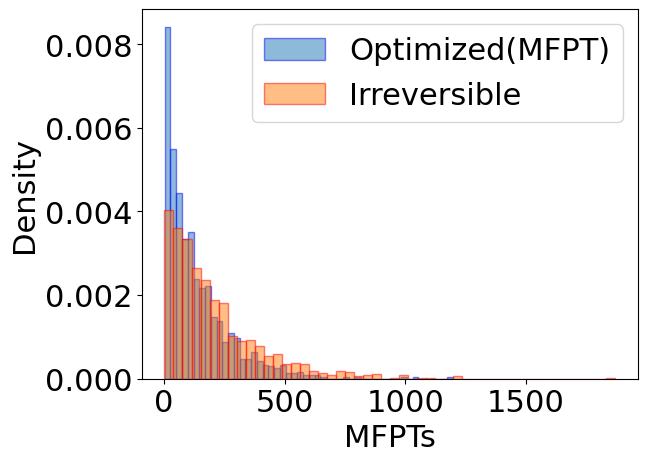

In [65]:
plt.figure()
plt.figure()
mpl.rcParams["font.size"]=22
plt.hist(np.array(result4)/10,bins=50,label="Optimized(MFPT)",density=True,alpha=0.5,edgecolor="b")
plt.hist(np.array(result2)/10,bins=50,label="Irreversible",density=True,alpha=0.5,edgecolor="r")
plt.xlabel("MFPTs")
plt.ylabel("Density")
# plt.xlim(0,400)
# plt.ylim(0,0.04)
plt.legend(loc="upper right")
# plt.xlabel("MFPTs")
# plt.ylabel("Density")
# plt.legend()

In [52]:
maxit = 500
prev3 = sample_traj(M_opt1,maxit,2*num_states**2,10000,irrev=True)
prev4 = sample_traj(M_opt2,maxit,2*num_states**2,10000,irrev=True)

In [53]:
N = num_states**2
prev3c = np.zeros((maxit,N),dtype=int)
for i  in range(maxit):
    for n in prev3[:,i]:
        prev3c[i,n] +=1

prev4c = np.zeros((maxit,N),dtype=int)
for i  in range(maxit):
    for n in prev4[:,i]:
        prev4c[i,n] +=1


ent3 = []
ent4 = []

for i in range(maxit):
    ent4.append(averge_difference(msm.peq,prev3c[i,:]))
    ent3.append(averge_difference(msm.peq,prev4c[i,:]))

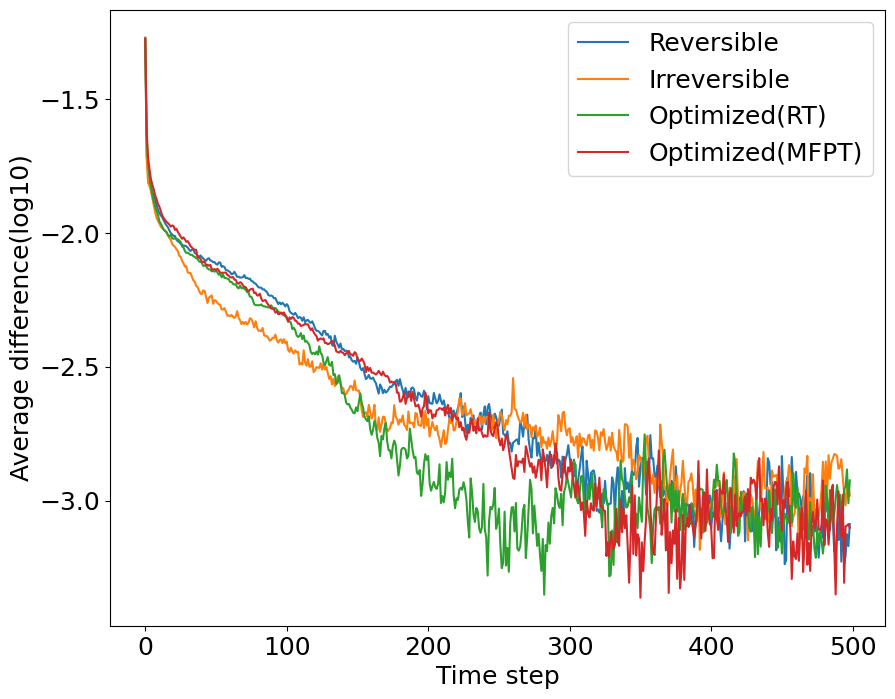

In [54]:

r = -1
plt.figure(figsize=(10,8))
plt.plot(np.log10(ent1[:r]),label="Reversible")
plt.plot(np.log10(ent2[:r]),label="Irreversible")
plt.plot(np.log10(ent3[:r]),label="Optimized(RT)")
plt.plot(np.log10(ent4[:r]),label="Optimized(MFPT)")
plt.ylabel("Average difference(log10)")
plt.xlabel("Time step")
plt.legend()

## Auto Correlation

In [12]:
n_states=25
max_timestep = 5000
M_rev = msm.M.T
M_irrev = linalg.expm(0.1*rate_irrev)
rev_ac,std_rev,traj_rev = average_correlation(M_rev,n_states,max_timestep,irrev=False)
irrev_ac,std_irrev,traj_irrev = average_correlation(M_irrev,2*n_states,max_timestep,irrev=True)
op_ac,std_opt,traj_opt1 = average_correlation(M_opt1,2*n_states,max_timestep,irrev=True)
op2_ac,std_opt2,traj_opt2 = average_correlation(M_opt2,2*n_states,max_timestep,irrev=True)

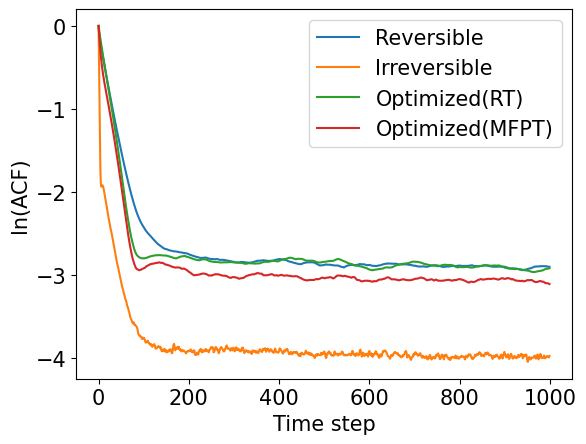

In [15]:
mpl.rcParams["font.size"]=15
plt.figure()
r = 1000
plt.plot(np.log(rev_ac[:r]),label="Reversible")
plt.plot(np.log(irrev_ac[:r]),label="Irreversible")
plt.plot(np.log(op_ac[:r]),label="Optimized(RT)")
plt.plot(np.log(op2_ac[:r]),label="Optimized(MFPT)")
plt.xlabel("Time step")
plt.ylabel("ln(ACF)")
t = np.linspace(0,10000,10000)
plt.legend()

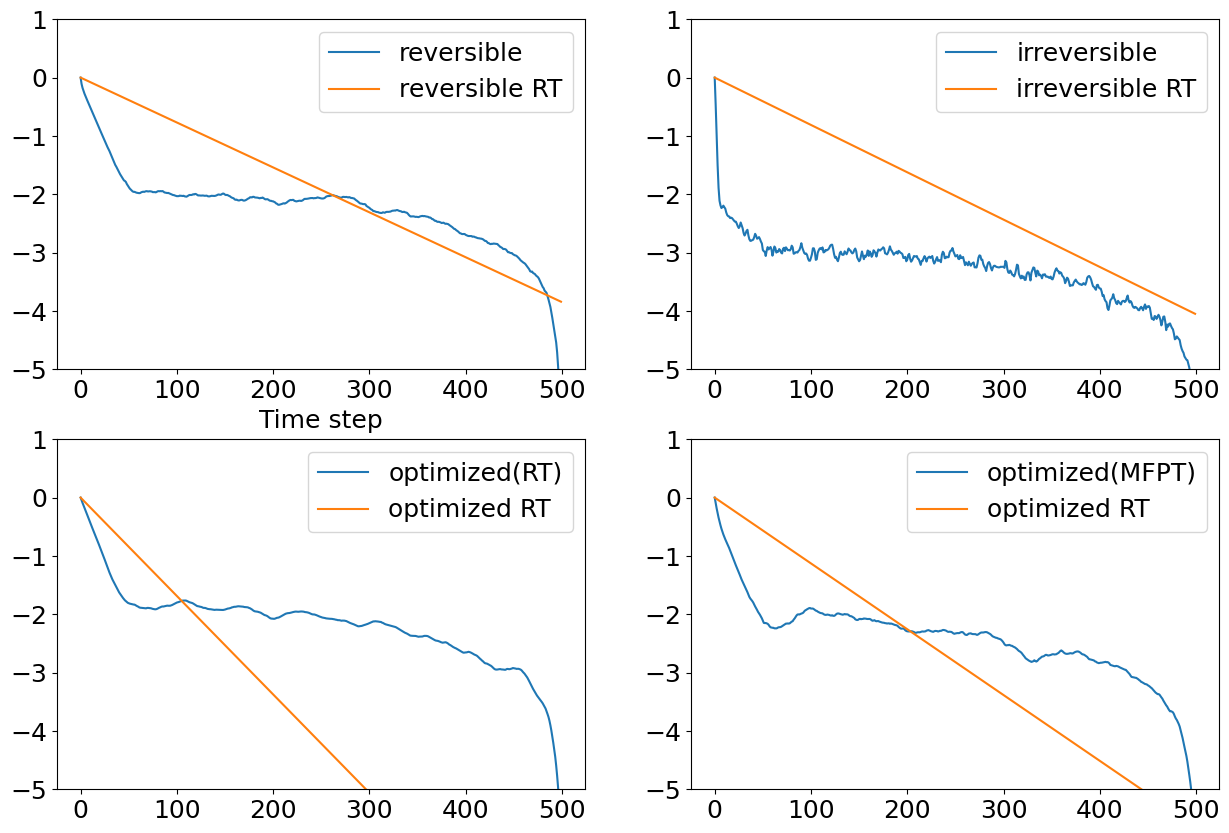

In [62]:
lagtime = 0.1
rt = relxaton_time(rate)
rti = relxaton_time(rate_irrev)
ylow = -5

plt.figure(figsize=(15,10) )
plt.subplot(2,2,1)
plt.plot(np.log(rev_ac),label="reversible")
plt.plot(-lagtime *t[:r]/rt,label = "reversible RT")
plt.xlabel("Time step")
plt.ylim(ylow,1)
plt.legend()

plt.subplot(2,2,2)
plt.plot(np.log(irrev_ac),label="irreversible")
plt.plot(-lagtime *t[:r]/rti,label="irreversible RT")
plt.ylim(ylow,1)
plt.legend()

plt.subplot(2,2,3)
plt.plot(np.log(op_ac),label="optimized(RT)")
plt.plot(-lagtime *t[:r]/opt_rt,label="optimized RT")
plt.ylim(ylow,1)
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.log(op2_ac),label="optimized(MFPT)")
plt.plot(-lagtime *t[:r]/opt_rt2,label="optimized RT")
plt.ylim(ylow,1)
plt.legend()

In [17]:
def traj_norm(traj_irrev):
    for i in range(traj_irrev.shape[0]):
        for j in range(traj_irrev.shape[1]):
            if traj_irrev[i,j] >= n_states:
                traj_irrev[i,j] -= n_states

traj_norm(traj_opt1)
traj_norm(traj_opt2)
traj_norm(traj_irrev)

Text(0, 0.5, 'state')

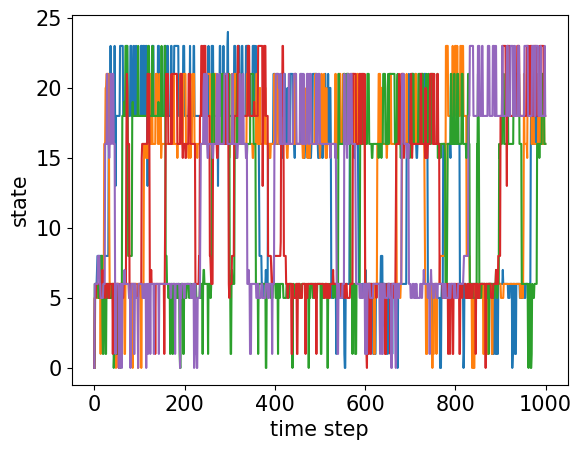

In [22]:
plt.figure()
for i in range(5):
    plt.plot(traj_irrev[i,:1000])
plt.xlabel("time step")
plt.ylabel("state")

Text(0, 0.5, 'state')

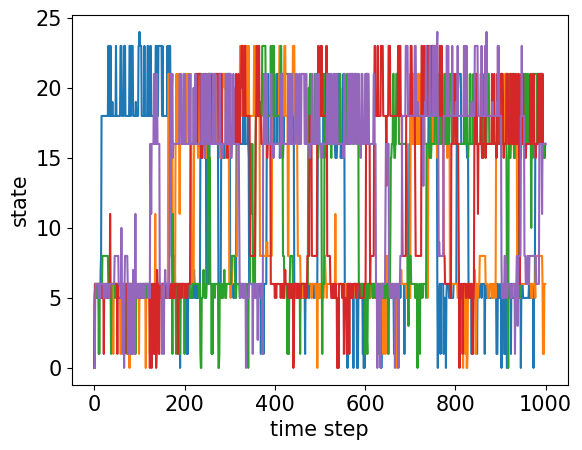

In [23]:
plt.figure()
for i in range(5):
    plt.plot(traj_rev[i,:1000])
plt.xlabel("time step")
plt.ylabel("state")